In [2]:
%load_ext autoreload
%autoreload 2

import time
import torch
import torch.nn as nn
import numpy as np
import pylab as plt
from sklearn.datasets import make_moons

from copy import deepcopy
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import MultivariateNormal

import sys
sys.path.append('./experiments/pseudo_batch/')
from updating import update_mc, predict_from_mc

lightning_trainer_kwargs = dict(
    default_root_dir='/tmp',
    enable_checkpointing=False,
    logger=False,
)

In [3]:
#plt.style.use('seaborn-v0_8-pastel')
plt.style.use('bmh')
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
# plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['figure.facecolor'] = 'white'

plt.rcParams['lines.linewidth'] = 2
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.grid"] = False
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


## Illustrative 2D Example 

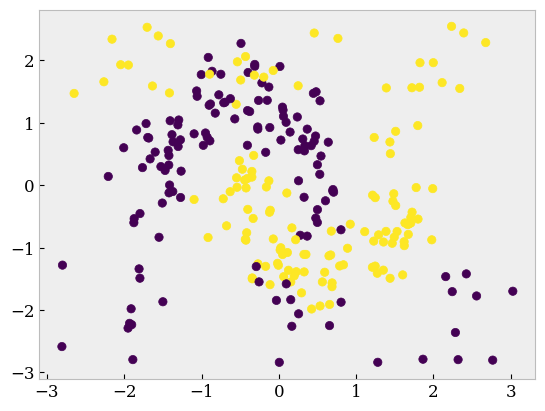

In [4]:
torch.manual_seed(1)
np.random.seed(42)
X, y = make_moons(200, noise=.2)
X = (X - X.mean(0)) / X.std(0)

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()
train_ds = TensorDataset(X, y)

X_new = torch.Tensor(10, 2).normal_(-3, 0.2).float()
y_new = torch.Tensor(10).zero_().long()
new_ds = TensorDataset(X_new, y_new)

X_new = torch.cat([
    MultivariateNormal(torch.tensor((-2., -2.)), covariance_matrix=.2*torch.eye(2)).sample((10,)),
    MultivariateNormal(torch.tensor((-2.,  2.)), covariance_matrix=.2*torch.eye(2)).sample((10,)),
    MultivariateNormal(torch.tensor(( 2., -2.)), covariance_matrix=.2*torch.eye(2)).sample((10,)),
    MultivariateNormal(torch.tensor(( 2.,  2.)), covariance_matrix=.2*torch.eye(2)).sample((10,)),
    MultivariateNormal(torch.tensor(( 0.,  2.)), covariance_matrix=.2*torch.eye(2)).sample((10,)),
    MultivariateNormal(torch.tensor(( 0.,  -2.)), covariance_matrix=.2*torch.eye(2)).sample((10,)),
])
y_new = torch.cat([
    torch.Tensor(10).fill_(0),
    torch.Tensor(10).fill_(1),
    torch.Tensor(10).fill_(0),
    torch.Tensor(10).fill_(1),
    torch.Tensor(10).fill_(1),
    torch.Tensor(10).fill_(0),
]).long()
new_ds = TensorDataset(X_new, y_new)


plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)
plt.show()

### Laplace-based Update


In [5]:
from lightning import Trainer
from dal_toolbox.models.laplace import LaplaceLayer, LaplaceModel

class Net(torch.nn.Module):
    def __init__(self, mean_field_factor, cov_likelihood, ridge_penalty=1):
        super().__init__()
        self.layer1 = nn.Linear(2, 100)
        self.layer2 = LaplaceLayer(in_features=100, out_features=2, mean_field_factor=mean_field_factor, cov_likelihood=cov_likelihood, ridge_penalty=ridge_penalty)
        self.act = nn.ReLU()

    def forward(self, x, return_features=False):
        x = self.layer1(x)
        x = self.act(x)
        return self.layer2(x, return_features=return_features)
    
    def forward_mean_field(self, x):
        x = self.layer1(x)
        x = self.act(x)
        return self.layer2.forward_mean_field(x)

    def forward_monte_carlo(self, x):
        x = self.layer1(x)
        x = self.act(x)
        return self.layer2.forward_monte_carlo(x)

In [6]:
torch.manual_seed(0)
np.random.seed(0)

mean_field_factor = 10
# net = LaplaceLayer(in_features=2, out_features=2, mean_field_factor=mean_field_factor)
net = Net(mean_field_factor=mean_field_factor, cov_likelihood='gaussian', ridge_penalty=1)

num_epochs = 400
optimizer = torch.optim.RAdam(net.parameters(), lr=1e-3, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
model = LaplaceModel(net, optimizer=optimizer, lr_scheduler=lr_scheduler)

trainer = Trainer(max_epochs=num_epochs, **lightning_trainer_kwargs)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Net              | 500   
1 | loss_fn       | CrossEntropyLoss | 0     
2 | train_metrics | ModuleDict       | 0     
3 | val_metrics   | ModuleDict       | 0     
---------------------------------------------------
500       Trainable params
0         Non-trainable params
500       Total params
0.002     Total estimated 

Epoch 399: 100%|██████████| 6/6 [00:00<00:00, 739.39it/s, train_loss=0.147] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 6/6 [00:00<00:00, 704.55it/s, train_loss=0.147]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   6%|▋         | 5/80 [00:00<00:00, 191.16it/s]

Predicting DataLoader 0: 100%|██████████| 80/80 [00:00<00:00, 769.12it/s]


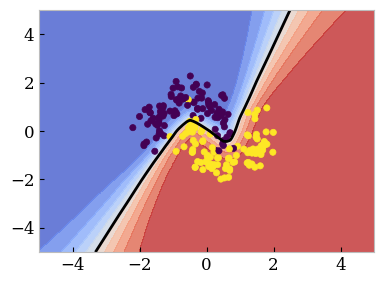

In [7]:
domain = 5
xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 101), torch.linspace(-domain, domain, 201))
zz = torch.stack((xx.ravel(), yy.ravel()), dim=1)

model.set_mean_field_factor(1)
predictions = trainer.predict(model, DataLoader(TensorDataset(zz, zz), batch_size=256))
logits = torch.cat([pred[0] for pred in predictions])
probas = logits.softmax(-1)[:, 1]

plt.figure(figsize=(4, 3))
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[0.5], colors='k')
plt.contourf(xx, yy, probas.reshape(xx.shape), cmap='coolwarm', levels=np.linspace(0, 1, 11), alpha=.8)
# for p in logits.softmax(-1).swapaxes(0, 1)[:10]:
#     plt.contour(xx, yy, p[:, 1].reshape(xx.shape), levels=[0.5], colors='k')
# plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c=y, s=20)
plt.tight_layout()
plt.savefig('plots/2d_normal.pdf')
plt.show()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   9%|▉         | 7/80 [00:00<00:00, 941.06it/s] 

Predicting DataLoader 0: 100%|██████████| 80/80 [00:00<00:00, 970.98it/s]


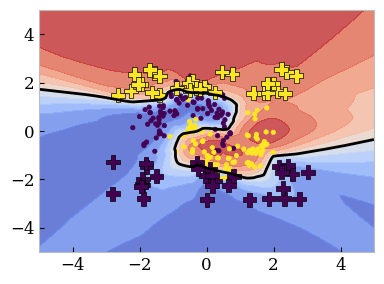

In [8]:
new_model = deepcopy(model)
update_loader = DataLoader(new_ds, batch_size=256)

torch.manual_seed(1)
new_model.update_posterior(update_loader, gamma=10)

new_model.set_mean_field_factor(10)
predictions = trainer.predict(new_model, DataLoader(TensorDataset(zz, zz), batch_size=256))
logits = torch.cat([pred[0] for pred in predictions])
probas = logits.softmax(-1)[:, 1]

plt.figure(figsize=(4, 3))
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[0.5], colors='k')
plt.contourf(xx, yy, probas.reshape(xx.shape), cmap='coolwarm', levels=np.linspace(0, 1, 11), alpha=.8)
# plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c=y, s=10)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new, s=100, marker='P', edgecolors='k')
plt.tight_layout()
plt.savefig('plots/2d_laplace_update.pdf')

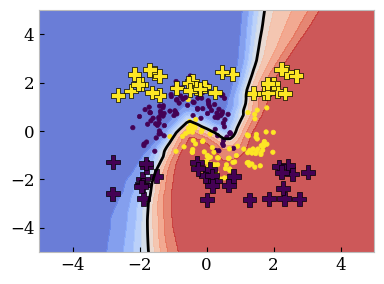

In [9]:
new_model = deepcopy(model)
update_loader = DataLoader(new_ds, batch_size=256)

new_model.set_mean_field_factor(10)
torch.manual_seed(1)
sampled_params, weights = update_mc(model, update_loader, mc_samples=10000, gamma=1)
predictions = predict_from_mc(model, DataLoader(TensorDataset(zz, zz), batch_size=256), sampled_params, weights)

logits = torch.cat([pred[0] for pred in predictions])
probas = logits.softmax(-1)[:, 1]

plt.figure(figsize=(4, 3))
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[0.5], colors='k')
plt.contourf(xx, yy, probas.reshape(xx.shape), cmap='coolwarm', levels=np.linspace(0, 1, 11), alpha=.8)
# plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c=y, s=10)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new, s=100, marker='P', edgecolors='k')
plt.tight_layout()
plt.savefig('plots/2d_mc_update.pdf')

In [10]:
from torch.utils.data import ConcatDataset
torch.manual_seed(0)
np.random.seed(0)

mean_field_factor = np.pi / 8
# net = LaplaceLayer(in_features=2, out_features=2, mean_field_factor=mean_field_factor)
net = Net(mean_field_factor=mean_field_factor, cov_likelihood='gaussian')

num_epochs = 200
optimizer = torch.optim.RAdam(net.parameters(), lr=1e-2, weight_decay=0.00)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
model = LaplaceModel(net, optimizer=optimizer, lr_scheduler=lr_scheduler)

trainer = Trainer(max_epochs=num_epochs, **lightning_trainer_kwargs)
train_loader = DataLoader(ConcatDataset([train_ds, new_ds]), batch_size=32, shuffle=True, drop_last=True)
trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Net              | 500   
1 | loss_fn       | CrossEntropyLoss | 0     
2 | train_metrics | ModuleDict       | 0     
3 | val_metrics   | ModuleDict       | 0     
---------------------------------------------------
500       Trainable params
0         Non-trainable params
500       Total params
0.002     Total estimated model params size (MB)


Epoch 0:  88%|████████▊ | 7/8 [00:00<00:00, 669.96it/s, train_loss=0.716]

Epoch 199: 100%|██████████| 8/8 [00:00<00:00, 680.07it/s, train_loss=0.186] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 8/8 [00:00<00:00, 651.24it/s, train_loss=0.186]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   6%|▋         | 5/80 [00:00<00:00, 882.19it/s]

Predicting DataLoader 0: 100%|██████████| 80/80 [00:00<00:00, 864.40it/s]


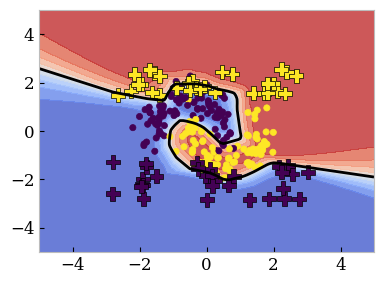

In [11]:
domain = 5
xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 101), torch.linspace(-domain, domain, 201))
zz = torch.stack((xx.ravel(), yy.ravel()), dim=1)

model.set_mean_field_factor(10)
predictions = trainer.predict(model, DataLoader(TensorDataset(zz, zz), batch_size=256))
logits = torch.cat([pred[0] for pred in predictions])
probas = logits.softmax(-1)[:, 1]

plt.figure(figsize=(4, 3))
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[0.5], colors='k')
plt.contourf(xx, yy, probas.reshape(xx.shape), cmap='coolwarm', levels=np.linspace(0, 1, 11), alpha=.8)
# plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c=y, s=20)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new, s=100, marker='P', edgecolors='k', label='New Data')
plt.tight_layout()
plt.savefig('plots/2d_retrained.pdf')
plt.show()

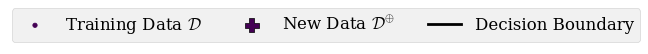

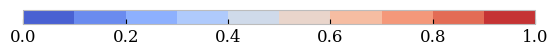

In [12]:
fig = plt.figure(figsize=(5, 5))
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[0.5], colors='k')
contourf = plt.contourf(xx, yy, probas.reshape(xx.shape), cmap='coolwarm', levels=np.linspace(0, 1, 11))
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, label='Training Data $\mathcal{D}$')
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new, s=100, marker='P', edgecolors='k', label='New Data $\mathcal{D}^{\oplus}$')
plt.tight_layout()
plt.plot(0, 0, '-k', label='Decision Boundary')
plt.gca().set_visible(False)
fig.legend(ncol=5)
plt.savefig('2d_legend.pdf', bbox_inches='tight', pad_inches=.1)
plt.show()
cax = plt.axes([0.0, 1.00, .8, .03])
plt.colorbar(contourf, cax=cax, orientation='horizontal')

plt.savefig('2d_colorbar.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

### GP-based Update using SNGP

In [13]:
from lightning import Trainer
from dal_toolbox.models.sngp import SNGPModel, RandomFeatureGaussianProcess
torch.manual_seed(0)
np.random.seed(0)

net = RandomFeatureGaussianProcess(
    in_features=2, 
    out_features=2,
    num_inducing=4*1024, 
    kernel_scale=.5,
    scale_random_features=True,
    mean_field_factor=np.pi / 8,
    cov_likelihood='categorical'
)
num_epochs = 200
param_dicts = [
    {"params": [p for n, p in net.named_parameters() if n != 'random_features.input_scale']},
    {"params": [p for n, p in net.named_parameters() if n == 'random_features.input_scale'], 'weight_decay': 0.01}
]
optimizer = torch.optim.RAdam(param_dicts, lr=1e-2, weight_decay=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
model = SNGPModel(net, optimizer=optimizer, lr_scheduler=lr_scheduler)

trainer = Trainer(
    max_epochs=num_epochs, 
    **lightning_trainer_kwargs,
)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                         | Params
---------------------------------------------------------------
0 | model         | RandomFeatureGaussianProcess | 8.2 K 
1 | loss_fn       | CrossEntropyLoss             | 0     
2 | train_metrics | ModuleDict                   | 0     
3 | val_metrics   | ModuleDict                   | 0     
---------------------------------------------------------------
8.2 K     Trainable params
0         Non-trainable params
8.2 K     Total params
0.033     Total estimated model params size (MB)


Epoch 199: 100%|██████████| 6/6 [00:00<00:00, 210.69it/s, train_loss=0.263]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 6/6 [00:00<00:00, 207.76it/s, train_loss=0.263]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 80/80 [00:00<00:00, 86.55it/s]


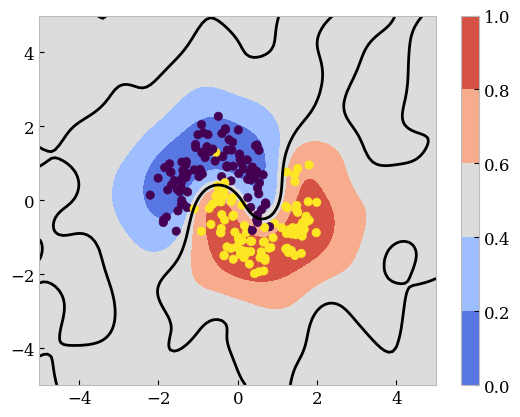

In [14]:
domain = 5
xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 101), torch.linspace(-domain, domain, 201))
zz = torch.stack((xx.ravel(), yy.ravel()), dim=1)

predictions = trainer.predict(model, DataLoader(TensorDataset(zz, zz), batch_size=256))
logits = torch.cat([pred[0] for pred in predictions])
probas = logits.softmax(-1)[:, 1]

plt.contour(xx, yy, probas.reshape(xx.shape), levels=[0.5], colors='k')
plt.contourf(xx, yy, probas.reshape(xx.shape), cmap='coolwarm', levels=np.linspace(0, 1, 6))
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 80/80 [00:00<00:00, 86.31it/s]


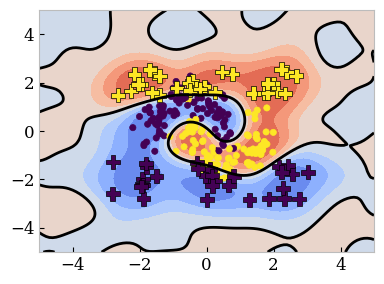

In [28]:
new_model = deepcopy(model)
update_loader = DataLoader(new_ds, batch_size=256)
new_model.update_posterior(update_loader, lmb=1, gamma=2, likelihood='gaussian')

predictions = trainer.predict(new_model, DataLoader(TensorDataset(zz, zz), batch_size=256))
logits = torch.cat([pred[0] for pred in predictions])
probas = logits.softmax(-1)[:, 1]

plt.figure(figsize=(4, 3))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[0.5], colors='k')
plt.contourf(xx, yy, probas.reshape(xx.shape), cmap='coolwarm', levels=np.linspace(0, 1, 11), alpha=1)
# plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c=y, s=20)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new, s=100, marker='P', edgecolors='k', label='New Data')
plt.tight_layout()
plt.savefig('plots/2d_sngp_update.pdf', bbox_inches='tight', pad_inches=0.1)

In [13]:
# traditional update using bayes theorem
new_model = deepcopy(model)
update_loader = DataLoader(new_ds, batch_size=256)
# update_mc(new_model, update_loader, 1000)

n_samples, n_members, n_classes = logits_mc.shape
# Define uniform prior
prior = torch.ones(n_members) / n_members
log_prior = torch.log(prior)  # uniform prior
# Compute log likelihood
log_likelihood = log_probas_mc.permute(1, 0, 2)[:, range(n_samples), targets].sum(dim=1)
# Compute log posterior
log_posterior = log_prior + log_likelihood
weights = log_posterior.softmax(0)
# weights = torch.exp(log_posterior - log_posterior.max())  # normalize log probs numerically stable
# weights /= weights.sum()

with torch.no_grad():
    _, zz_phi = new_model.model(zz, return_random_features=True)
logits_mc = torch.einsum('nd,ekd->nek', zz_phi, sampled_params)
probas_mc = logits_mc.softmax(-1)
probas = torch.einsum('e,nek->nk', weights, probas_mc)
probas = probas[:, 1]

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)
# for p in probas_mc.permute(1, 0, 2): plt.contour(xx, yy, p[:, 1].reshape(xx.shape), levels=[0.5], colors='k')
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[0.5], colors='k')
plt.contourf(xx, yy, probas.reshape(xx.shape), cmap='coolwarm', levels=np.linspace(0, 1, 6))
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)

TypeError: forward() got an unexpected keyword argument 'return_features'